In [2]:
import cv2
import sys

# 알파 채널을 마스크 영상으로 이용
src = cv2.imread("cat.bmp", cv2.IMREAD_COLOR)
logo = cv2.imread("opencv-logo-white.png", cv2.IMREAD_UNCHANGED)

if src is None or logo is None:
    print("Image load failed!")
    sys.exit()

mask = logo[:, :, 3]  # 알파 채널을 마스크로 사용
logo2 = logo[:, :, :-1]  # 알파 채널을 제외한 로고 영상
h, w = mask.shape[:2]  # 마스크 영상의 크기
crop = src[10 : 10 + h, 10 : 10 + w]  # src 영상에서 로고를 붙일 영역 추출

cv2.copyTo(logo2, mask, crop)  # 로고를 붙일 영역에 로고 영상 복사

cv2.imshow("src", src)
cv2.imshow("logo", logo)
cv2.imshow("mask", mask)
cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Camera open failed!")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        print("Frame read failed!")
        break

    inversed = ~frame

    cv2.imshow("frame", frame)
    cv2.imshow("inversed", inversed)

    if cv2.waitKey(10) == 27:  # ESC 키를 누르면 종료
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
cap2 = cv2.VideoCapture("video1.mp4")

fps = round(cap2.get(cv2.CAP_PROP_FPS))
delay = round(1000 / fps)  # 프레임 간격 계산

while True:
    ret, frame = cap2.read()

    inversed = ~frame
    cv2.imshow("frame", frame)
    cv2.imshow("inversed", inversed)

    if cv2.waitKey(delay) == 27:
        break

cap2.release()
cv2.destroyAllWindows()

TypeError: bad operand type for unary ~: 'NoneType'

: 

In [3]:
cap3 = cv2.VideoCapture()

w = round(cap3.get(cv2.CAP_PROP_FRAME_WIDTH))
h = round(cap3.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*"DIVX")  # *"DIVX" == "D", "I", "V", "X"
out = cv2.VideoWriter("output.avi", fourcc, 30, (w, h))

while True:
    ret, frame = cap3.read()

    inversed = ~frame
    out.write(inversed)

    cv2.imshow("frame", frame)
    cv2.imshow("inversed", inversed)

    if cv2.waitKey(10) == 27:
        break

TypeError: bad operand type for unary ~: 'NoneType'

In [9]:
import cv2
import numpy as np
import sys
import os


def combine_videos_wipe(video1_path, video2_path, output_path):
    """
    Combines two videos with a wipe transition:
    1. Play video1 alone until its midpoint.
    2. From midpoint to end of video1, video2 wipes in from left to right,
       gradually covering video1.
    3. Play the remaining part of video2 alone, resized to fit video1's dimensions.

    Args:
        video1_path (str): Path to the first video file.
        video2_path (str): Path to the second video file.
        output_path (str): Path to save the combined output video.
    """
    print("비디오 처리 시작 (와이프 효과 적용)...")

    # --- 1. 비디오 열기 및 정보 확인 ---
    cap1 = cv2.VideoCapture(video1_path)
    cap2 = cv2.VideoCapture(video2_path)

    if not cap1.isOpened():
        print(f"오류: '{video1_path}' 파일을 열 수 없습니다.")
        return
    if not cap2.isOpened():
        print(f"오류: '{video2_path}' 파일을 열 수 없습니다.")
        cap1.release()
        return

    # 비디오 1 정보
    w1 = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
    h1 = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps1 = cap1.get(cv2.CAP_PROP_FPS)
    total_frames1 = int(cap1.get(cv2.CAP_PROP_FRAME_COUNT))

    # 프레임 수나 FPS 정보 읽기 실패 시 대처 (이전 코드와 동일)
    if total_frames1 <= 0 or fps1 <= 0:
        ret, frame = cap1.read()
        if ret:
            h1, w1 = frame.shape[:2]
            print(
                f"경고: 비디오 1의 메타데이터(프레임 수/FPS) 읽기 실패. 첫 프레임 기준({w1}x{h1})으로 진행."
            )
            # 프레임 수 재계산 시도 (이전 코드와 동일)
            cap1.set(cv2.CAP_PROP_POS_FRAMES, 0)
            count = 0
            while True:
                ret_c, _ = cap1.read()
                if not ret_c:
                    break
                count += 1
            total_frames1 = count
            cap1.set(cv2.CAP_PROP_POS_FRAMES, 0)  # 위치 초기화
            if total_frames1 == 0:
                print("오류: 비디오 1의 프레임을 셀 수 없습니다.")
                cap1.release()
                cap2.release()
                return
            print(f"비디오 1의 계산된 전체 프레임 수: {total_frames1}")
            if fps1 <= 0:
                fps1 = 30  # FPS를 모를 경우 기본값 사용
        else:
            print("오류: 비디오 1의 첫 프레임을 읽을 수 없습니다.")
            cap1.release()
            cap2.release()
            return

    # 비디오 2 정보
    w2 = int(cap2.get(cv2.CAP_PROP_FRAME_WIDTH))
    h2 = int(cap2.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames2 = int(cap2.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"영상 1: {w1}x{h1}, {fps1:.2f} FPS, {total_frames1} 프레임")
    print(f"영상 2: {w2}x{h2}, {total_frames2} 프레임")

    if total_frames1 == 0:
        print("오류: 비디오 1의 길이가 0입니다.")
        cap1.release()
        cap2.release()
        return

    # --- 2. 계산 ---
    mid_frame = total_frames1 // 2
    num_transition_frames = total_frames1 - mid_frame
    if num_transition_frames <= 0:
        print("경고: 비디오 1의 길이가 너무 짧아 전환 효과를 적용할 수 없습니다.")
        num_transition_frames = 1  # 오류 방지
    output_fps = fps1

    print(f"전환 시작 프레임: {mid_frame}")
    print(f"전환 구간 길이: {num_transition_frames} 프레임")

    # --- 3. 출력 비디오 설정 ---
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(output_path, fourcc, output_fps, (w1, h1))
    if not writer.isOpened():
        print(f"오류: 출력 파일 '{output_path}'을(를) 열 수 없습니다.")
        cap1.release()
        cap2.release()
        return

    # --- 4. 프레임 처리 루프 ---
    frame_count = 0
    video2_frame_idx = 0  # video2의 현재 읽은 프레임 인덱스 (Phase 2, 3 걸쳐 사용)
    last_good_frame2 = None  # video2가 중간에 끝나면 마지막 프레임 사용

    try:
        # Phase 1: Video 1 Alone (0 ~ mid_frame - 1)
        print("Phase 1: 비디오 1 재생 중...")
        while frame_count < mid_frame:
            ret1, frame1 = cap1.read()
            if not ret1:
                print(f"오류: 비디오 1 재생 중 예상치 못한 종료 (프레임 {frame_count})")
                raise StopIteration("Video 1 ended prematurely")

            writer.write(frame1)
            frame_count += 1
            if frame_count % 100 == 0:
                print(f"  Phase 1 진행: {frame_count}/{mid_frame} 프레임")

        # Phase 2: Wipe Transition (mid_frame ~ total_frames1 - 1)
        print("Phase 2: 비디오 2 와이프 전환 시작...")
        cap2.set(cv2.CAP_PROP_POS_FRAMES, 0)  # 와이프 시작 시 비디오 2는 처음부터
        video2_frame_idx = 0  # Phase 2 시작 시 비디오 2 인덱스 초기화

        while frame_count < total_frames1:
            ret1, frame1 = cap1.read()
            if not ret1:
                print(f"오류: 비디오 1 재생 중 예상치 못한 종료 (프레임 {frame_count})")
                raise StopIteration("Video 1 ended prematurely in Phase 2")

            ret2, frame2 = cap2.read()
            if ret2:
                last_good_frame2 = frame2  # 새 프레임 읽기 성공 시 업데이트
                video2_frame_idx += 1  # 비디오 2 프레임 인덱스 증가
            elif last_good_frame2 is None:
                # video2가 너무 짧아서 와이프 시작도 전에 끝난 경우
                print(
                    "경고: 비디오 2가 와이프 전환 시작 전에 종료되었습니다. 비디오 1만 계속 표시합니다."
                )
                writer.write(frame1)  # 원본 비디오 1 프레임만 씀
                frame_count += 1
                continue  # 다음 프레임으로

            # 와이프 효과에 사용할 비디오 2 프레임 결정 (현재 프레임 또는 마지막 유효 프레임)
            current_frame2_source = last_good_frame2 if not ret2 else frame2

            # 현재 프레임에서의 와이프 진행률 및 너비 계산
            # (frame_count - mid_frame)는 0부터 시작하므로 +1 해줘서 첫 프레임부터 너비가 있도록 함
            progress = (frame_count - mid_frame + 1) / num_transition_frames
            current_wipe_width = min(
                w1, int(w1 * progress)
            )  # 최종 너비가 w1을 넘지 않도록 함

            output_frame = frame1.copy()  # 원본 프레임 복사 후 수정

            if current_wipe_width > 0 and current_frame2_source is not None:
                try:
                    # 와이프 효과를 위해 비디오 2 프레임을 비디오 1 크기로 리사이즈
                    # (매 프레임 리사이즈는 비효율적일 수 있으나, 가장 간단한 방법)
                    resized_frame2_full = cv2.resize(
                        current_frame2_source, (w1, h1), interpolation=cv2.INTER_AREA
                    )

                    # 리사이즈된 비디오 2 프레임에서 와이프 너비만큼 좌측 부분을 가져옴
                    wipe_part = resized_frame2_full[:, 0:current_wipe_width]

                    # 원본 프레임(복사본)의 좌측에 와이프 부분을 덮어<0xEC><0x94><0x81>
                    # roi = output_frame[:, 0:current_wipe_width] # 이 줄은 필요 없음
                    if wipe_part.shape[1] > 0:  # 너비가 0보다 클 때만 복사
                        if (
                            output_frame[:, 0:current_wipe_width].shape
                            == wipe_part.shape
                        ):
                            output_frame[:, 0:current_wipe_width] = wipe_part
                        else:
                            # 크기 불일치 발생 시 (이론상으론 없어야 함)
                            print(
                                f"경고: 프레임 {frame_count} 와이프 크기 불일치. Target: {output_frame[:, 0:current_wipe_width].shape}, Source: {wipe_part.shape}"
                            )
                            # 가능한 만큼만 복사 시도
                            copy_w = min(
                                output_frame.shape[1],
                                wipe_part.shape[1],
                                current_wipe_width,
                            )
                            copy_h = min(output_frame.shape[0], wipe_part.shape[0])
                            output_frame[0:copy_h, 0:copy_w] = wipe_part[
                                0:copy_h, 0:copy_w
                            ]

                except Exception as e:
                    print(f"경고: 프레임 {frame_count} 와이프 처리 중 오류: {e}")
                    # 오류 발생 시 그냥 원본 frame1 (output_frame 초기값) 사용

            writer.write(output_frame)
            frame_count += 1

            # 진행률 표시
            if (frame_count - mid_frame) % 50 == 0:
                print(
                    f"  Phase 2 진행: {frame_count - mid_frame}/{num_transition_frames} 프레임 (와이프 너비 {current_wipe_width}/{w1})"
                )

        # Phase 3: Video 2 Alone (Remaining frames of video 2)
        print("Phase 3: 비디오 2 남은 부분 재생 중...")
        # 비디오 2를 Phase 2에서 마지막으로 읽은 프레임 다음부터 계속 읽도록 설정
        # cap2.set()은 부정확할 수 있으므로, 그냥 계속 read() 호출
        # 이미 video2_frame_idx 만큼 읽었음

        while True:
            if (
                last_good_frame2 is None and not ret2
            ):  # Phase 2에서 이미 비디오 2가 끝났으면 종료
                print("비디오 2가 이미 Phase 2에서 종료되어 Phase 3은 건너뜁니다.")
                break

            # ret2가 False여도 last_good_frame2를 사용했으므로, 여기서 다시 읽어야 함
            ret2, frame2 = cap2.read()
            if not ret2:
                print("비디오 2의 남은 부분 재생 완료.")
                break  # 비디오 2 종료
            video2_frame_idx += 1  # Phase 3에서 읽은 프레임 카운트

            # Phase 3 처리: 비디오 2 프레임을 비디오 1 크기에 맞춰 리사이즈 (레터박스/필러박스)
            h2_curr, w2_curr = frame2.shape[:2]
            if h2_curr == 0 or w2_curr == 0:
                continue

            ar_out = w1 / h1
            ar_in = w2_curr / h2_curr
            output_frame_p3 = np.zeros((h1, w1, 3), dtype=np.uint8)  # 검은 배경

            if ar_in > ar_out:  # 레터박스
                new_h = int(w1 / ar_in)
                resized_frame = cv2.resize(
                    frame2, (w1, new_h), interpolation=cv2.INTER_AREA
                )
                pad_y = (h1 - new_h) // 2
                output_frame_p3[pad_y : pad_y + new_h, 0:w1] = resized_frame
            elif ar_in < ar_out:  # 필러박스
                new_w = int(h1 * ar_in)
                resized_frame = cv2.resize(
                    frame2, (new_w, h1), interpolation=cv2.INTER_AREA
                )
                pad_x = (w1 - new_w) // 2
                output_frame_p3[0:h1, pad_x : pad_x + new_w] = resized_frame
            else:  # 비율 같음
                output_frame_p3 = cv2.resize(
                    frame2, (w1, h1), interpolation=cv2.INTER_AREA
                )

            writer.write(output_frame_p3)

            # 진행률 표시
            if (video2_frame_idx - (num_transition_frames)) % 100 == 0:
                remaining_frames2_str = (
                    f"{total_frames2 - video2_frame_idx}" if total_frames2 > 0 else "??"
                )
                print(
                    f"  Phase 3 진행: 비디오 2 프레임 {video2_frame_idx}/{total_frames2} (남은 프레임 {remaining_frames2_str})"
                )

    except StopIteration as e:
        print(f"처리 중단: {e}")
    except Exception as e:
        print(f"예상치 못한 오류 발생: {e}")
        import traceback

        traceback.print_exc()  # 상세 오류 출력
    finally:
        # --- 5. 자원 해제 ---
        print("자원 해제 중...")
        cap1.release()
        cap2.release()
        writer.release()
        print(f"비디오 처리가 완료되어 '{output_path}'에 저장되었습니다.")


# --- 실행 예시 ---
# 실제 비디오 파일 경로로 변경해주세요.
video1_file = "video1.mp4"
video2_file = "video2.mp4"
output_file = "combined_wipe_video.mp4"

# 파일 존재 여부 확인
if not os.path.exists(video1_file):
    print(f"오류: 입력 파일 '{video1_file}'을 찾을 수 없습니다.")
    sys.exit(1)
if not os.path.exists(video2_file):
    print(f"오류: 입력 파일 '{video2_file}'을 찾을 수 없습니다.")
    sys.exit(1)

# 함수 호출
combine_videos_wipe(video1_file, video2_file, output_file)

비디오 처리 시작 (와이프 효과 적용)...
영상 1: 1280x720, 24.00 FPS, 85 프레임
영상 2: 1280x720, 121 프레임
전환 시작 프레임: 42
전환 구간 길이: 43 프레임
Phase 1: 비디오 1 재생 중...
Phase 2: 비디오 2 와이프 전환 시작...
Phase 3: 비디오 2 남은 부분 재생 중...
비디오 2의 남은 부분 재생 완료.
자원 해제 중...
비디오 처리가 완료되어 'combined_wipe_video.mp4'에 저장되었습니다.


In [ ]:
src = cv2.imread("lenna.bmp", cv2.IMREAD_GRAYSCALE)

dst1 = cv2.add(src, 100)

dst2 = src + 100

dst3 = np.clip(src + 100.0, 0, 255).astype(np.uint8)

cv2.imshow("src", src)
cv2.imshow("dst1", dst1)
cv2.imshow("dst2", dst2)
cv2.imshow("dst3", dst3)
cv2.waitKey()
cv2.destroyAllWindows()

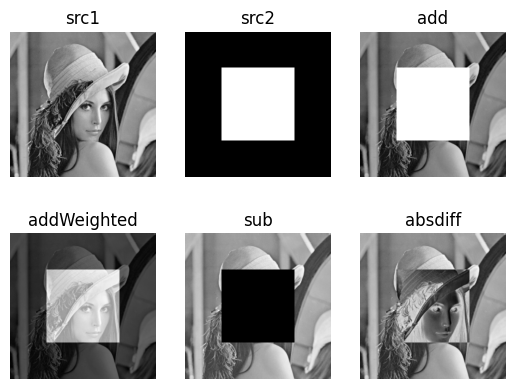

In [17]:
import cv2
import matplotlib.pyplot as plt

src1 = cv2.imread("lenna256.bmp", cv2.IMREAD_GRAYSCALE)
src2 = cv2.imread("square.bmp", cv2.IMREAD_GRAYSCALE)

add = cv2.add(src1, src2)  # src1 + src2
addWeighted = cv2.addWeighted(src1, 0.5, src2, 0.5, 0)  # src1 * 0.5 + src2 * 0.5 + 0
sub = cv2.subtract(src1, src2)  # src1 - src2
absdiff = cv2.absdiff(src1, src2)  # |src1 - src2|

plt.subplot(231), plt.axis("off"), plt.imshow(src1, "gray"), plt.title("src1")
plt.subplot(232), plt.axis("off"), plt.imshow(src2, "gray"), plt.title("src2")
plt.subplot(233), plt.axis("off"), plt.imshow(add, "gray"), plt.title("add")
plt.subplot(234), plt.axis("off"), plt.imshow(addWeighted, "gray"), plt.title("addWeighted")
plt.subplot(235), plt.axis("off"), plt.imshow(sub, "gray"), plt.title("sub")
plt.subplot(236), plt.axis("off"), plt.imshow(absdiff, "gray"), plt.title("absdiff")
plt.show()



In [ ]:
import sys
import numpy as np
import cv2


# 컬러 영상 불러오기
src = cv2.imread('candies.png', cv2.IMREAD_COLOR)

if src is None:
    print('Image load failed!')
    sys.exit()

# 컬러 영상 속성 확인
print('src.shape:', src.shape)  # src.shape: (480, 640, 3)
print('src.dtype:', src.dtype)  # src.dtype: uint8

# RGB 색 평면 분할
b_plane, g_plane, r_plane = cv2.split(src)

#b_plane = src[:, :, 0]
#g_plane = src[:, :, 1]
#r_plane = src[:, :, 2]

cv2.imshow('src', src)
cv2.imshow('B_plane', b_plane)
cv2.imshow('G_plane', g_plane)
cv2.imshow('R_plane', r_plane)
cv2.waitKey()

cv2.destroyAllWindows()



src.shape: (480, 640, 3)
src.dtype: uint8
